## Import library

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

## Define path

In [2]:
path = "../img/detection"
path_dog = os.path.join(path, 'dog')
path_nodog = os.path.join(path, 'no_dog')

path_dog_corgi = os.path.join(path_dog, 'corgi')
path_dog_shiba = os.path.join(path_dog, 'shiba')
path_dog_gr = os.path.join(path_dog, 'gr')

path_nodog_parrot = os.path.join(path_nodog, 'parrot')
path_nodog_tiger = os.path.join(path_nodog, 'tiger')
path_nodog_rabbit = os.path.join(path_nodog, 'rabbit')
class_names = ['dog', 'no_dog']

In [3]:
# clear error image
from PIL import Image
path_list = [path_dog_corgi, path_dog_shiba, path_dog_gr, path_nodog_parrot,
            path_nodog_tiger, path_nodog_rabbit]

for p in path_list:
    file_list = os.listdir(p)
    for n in file_list:
        file_path = os.path.join(p, n)
        try:
            img = Image.open(file_path)
        except:
            os.remove(file_path)

## EDA

In [4]:
split = 0.2

In [5]:
num_corgi = len(os.listdir(path_dog_corgi))
num_shiba = len(os.listdir(path_dog_shiba))
num_gr = len(os.listdir(path_dog_gr))
num_dogs = num_gr + num_shiba + num_corgi

num_parrot = len(os.listdir(path_nodog_parrot))
num_tiger = len(os.listdir(path_nodog_tiger))
num_rabbit = len(os.listdir(path_nodog_rabbit))
num_nodogs = num_parrot + num_tiger + num_rabbit

total_img_num = num_dogs + num_nodogs

total_val = total_img_num * split
total_train = total_img_num - total_val

print('total dog images:', num_dogs)
print('total no_dog images:', num_nodogs)
print('total images:', total_img_num)
print('number of training data:', total_train)
print('number of validation:', total_val)

total dog images: 3321
total no_dog images: 3199
total images: 6520
number of training data: 5216.0
number of validation: 1304.0


## Train test split

In [21]:
epochs = 30 #10
IMG_HEIGHT = 112
IMG_WIDTH = 112
batch_size = 128

In [22]:
# Generator
data_generator = ImageDataGenerator(rescale=1./255, validation_split=split)

In [23]:
# Load images from the disk, applies rescaling, and resizes the images

train_generator = data_generator.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training') # set as training data

validation_generator = data_generator.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='validation') # set as validation data

Found 5217 images belonging to 2 classes.
Found 1303 images belonging to 2 classes.


## Labels

In [ ]:
import collections

def count_label(generator):
    l = len(generator)
    counter = collections.Counter()
    for i in range(l):
        _, label = generator[i]
        unique, counts = np.unique(label, return_counts=True)
        count_label = dict(zip(unique, counts))
        counter.update(count_label) 
    result = dict(counter)
    return result

In [ ]:
train_count = count_label(train_generator)
val_count = count_label(validation_generator)

print("Training labels:")
print(train_count)
print("Validation labels:")
print(val_count)

In [ ]:
def get_image_label(generator):
    l = len(generator)
    images = []
    labels = []
    for i in range(l):
        image, label = generator[i]
        images.append(image.tolist())
        labels.append(label.tolist())
    return [images, labels]

In [ ]:
val_img_lab = get_image_label(validation_generator)

## Sample visualisation

In [11]:
sample_img_train, sample_label_train = next(train_generator)

In [ ]:
def plotImg(img, label):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img[i])
        plt.xlabel(class_names[int(label[i])])
    plt.show()

In [ ]:
plotImg(sample_img_train, sample_label_train)

## 7. 0.8 0.8

In [16]:
model_6 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.8),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.8),
    Dense(1, activation='sigmoid')
])

model_6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_6.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 112, 112, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)       

In [17]:
history = model_6.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/40
 3/40 [=>............................] - ETA: 19s - loss: 0.5095 - acc: 0.7500

C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


40/40 [==============================] - 27s 672ms/step - loss: 0.6183 - acc: 0.6544 - val_loss: 0.5242 - val_acc: 0.7375
Epoch 2/40
40/40 [==============================] - 26s 648ms/step - loss: 0.4931 - acc: 0.7754 - val_loss: 0.4379 - val_acc: 0.8031
Epoch 3/40
40/40 [==============================] - 27s 682ms/step - loss: 0.4362 - acc: 0.8119 - val_loss: 0.4190 - val_acc: 0.8133
Epoch 4/40
40/40 [==============================] - 25s 637ms/step - loss: 0.4234 - acc: 0.8226 - val_loss: 0.4075 - val_acc: 0.8211
Epoch 5/40
40/40 [==============================] - 26s 653ms/step - loss: 0.3933 - acc: 0.8375 - val_loss: 0.3781 - val_acc: 0.8328
Epoch 6/40
40/40 [==============================] - 27s 667ms/step - loss: 0.3911 - acc: 0.8340 - val_loss: 0.3734 - val_acc: 0.8430
Epoch 7/40
40/40 [==============================] - 25s 633ms/step - loss: 0.3618 - acc: 0.8514 - val_loss: 0.3728 - val_acc: 0.8469
Epoch 8/40
40/40 [==============================] - 27s 668ms/step - loss: 0.368

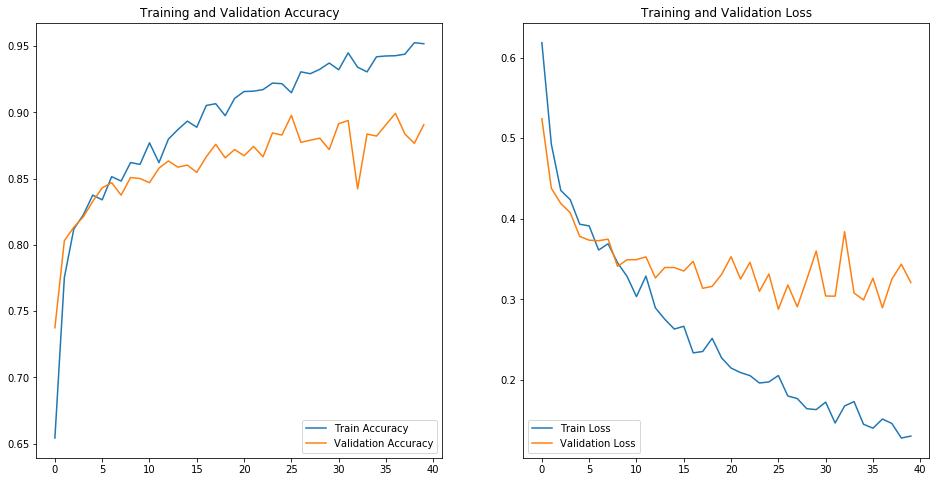

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

## 1. no dropout

In [12]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
____________________________

In [14]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = total_train // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_val // batch_size
)

Epoch 1/20


C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


41/41 [==============================] - 80s 2s/step - loss: 0.8352 - acc: 0.6310 - val_loss: 0.5327 - val_acc: 0.7617
Epoch 2/20
41/41 [==============================] - 68s 2s/step - loss: 0.4592 - acc: 0.7941 - val_loss: 0.4633 - val_acc: 0.7961
Epoch 3/20
41/41 [==============================] - 68s 2s/step - loss: 0.4060 - acc: 0.8245 - val_loss: 0.4767 - val_acc: 0.7789
Epoch 4/20
41/41 [==============================] - 68s 2s/step - loss: 0.3359 - acc: 0.8641 - val_loss: 0.4312 - val_acc: 0.8133
Epoch 5/20
41/41 [==============================] - 68s 2s/step - loss: 0.2730 - acc: 0.8911 - val_loss: 0.4247 - val_acc: 0.8219
Epoch 6/20
41/41 [==============================] - 68s 2s/step - loss: 0.2113 - acc: 0.9196 - val_loss: 0.4509 - val_acc: 0.8172
Epoch 7/20
41/41 [==============================] - 69s 2s/step - loss: 0.1482 - acc: 0.9458 - val_loss: 0.5191 - val_acc: 0.7992
Epoch 8/20
41/41 [==============================] - 68s 2s/step - loss: 0.1182 - acc: 0.9589 - val_lo

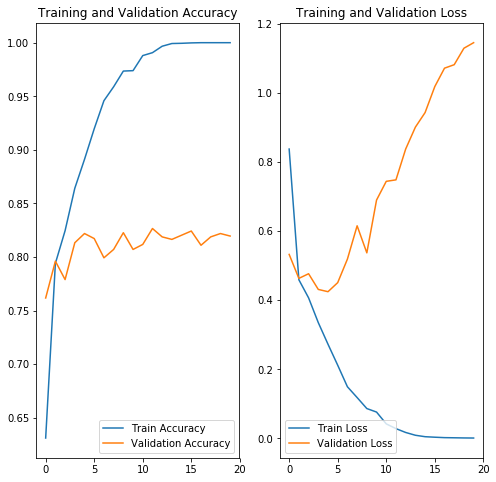

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(val_img_lab[0],  val_img_lab[1], verbose=2)

print('\nTest accuracy:', test_acc)

## 2. Dropout 0.5

In [16]:
model_1 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)       

In [17]:
history = model_1.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/20
 3/41 [=>............................] - ETA: 1:23 - loss: 2.7887 - acc: 0.4661

C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


41/41 [==============================] - 72s 2s/step - loss: 0.8719 - acc: 0.5773 - val_loss: 0.5303 - val_acc: 0.7664
Epoch 2/20
41/41 [==============================] - 70s 2s/step - loss: 0.4813 - acc: 0.7778 - val_loss: 0.4779 - val_acc: 0.7805
Epoch 3/20
41/41 [==============================] - 70s 2s/step - loss: 0.4509 - acc: 0.7989 - val_loss: 0.4588 - val_acc: 0.8062
Epoch 4/20
41/41 [==============================] - 70s 2s/step - loss: 0.3916 - acc: 0.8377 - val_loss: 0.4124 - val_acc: 0.8164
Epoch 5/20
41/41 [==============================] - 70s 2s/step - loss: 0.3560 - acc: 0.8496 - val_loss: 0.4292 - val_acc: 0.8172
Epoch 6/20
41/41 [==============================] - 70s 2s/step - loss: 0.2962 - acc: 0.8822 - val_loss: 0.4650 - val_acc: 0.7867
Epoch 7/20
41/41 [==============================] - 70s 2s/step - loss: 0.2534 - acc: 0.8995 - val_loss: 0.4799 - val_acc: 0.8078
Epoch 8/20
41/41 [==============================] - 70s 2s/step - loss: 0.1997 - acc: 0.9191 - val_lo

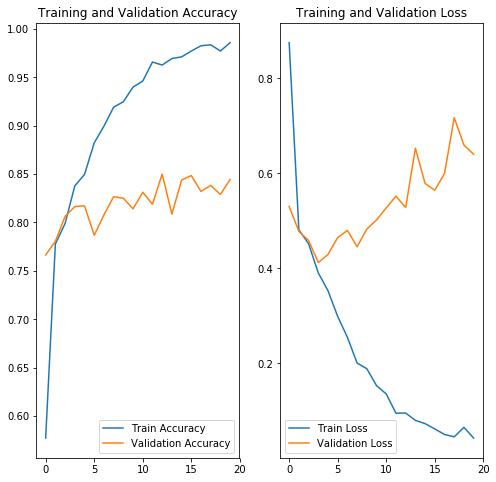

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

## 3. 0.5 0.7

In [19]:
model_2 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)       

In [20]:
history = model_2.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/20
12/41 [=======>......................] - ETA: 50s - loss: 0.9884 - acc: 0.5215

C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


41/41 [==============================] - 71s 2s/step - loss: 0.7134 - acc: 0.6238 - val_loss: 0.5281 - val_acc: 0.7477
Epoch 2/20
41/41 [==============================] - 69s 2s/step - loss: 0.5160 - acc: 0.7620 - val_loss: 0.5081 - val_acc: 0.7352
Epoch 3/20
41/41 [==============================] - 69s 2s/step - loss: 0.4503 - acc: 0.8016 - val_loss: 0.4789 - val_acc: 0.7578
Epoch 4/20
41/41 [==============================] - 70s 2s/step - loss: 0.3997 - acc: 0.8329 - val_loss: 0.4043 - val_acc: 0.8281
Epoch 5/20
41/41 [==============================] - 70s 2s/step - loss: 0.3708 - acc: 0.8453 - val_loss: 0.4167 - val_acc: 0.8211
Epoch 6/20
41/41 [==============================] - 70s 2s/step - loss: 0.3291 - acc: 0.8620 - val_loss: 0.3963 - val_acc: 0.8344
Epoch 7/20
41/41 [==============================] - 80s 2s/step - loss: 0.3020 - acc: 0.8754 - val_loss: 0.4398 - val_acc: 0.8055
Epoch 8/20
41/41 [==============================] - 72s 2s/step - loss: 0.2586 - acc: 0.8991 - val_lo

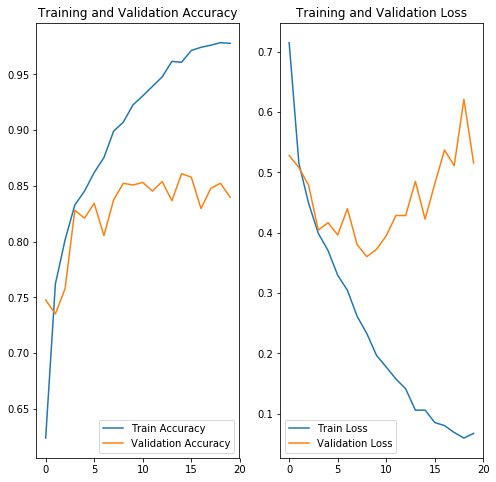

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

## 5. 0.2 0.5 0.7 (overfit)

In [12]:
model_4 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

model_4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 28, 64)       

In [13]:
history = model_4.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/20
 1/41 [..............................] - ETA: 4:21 - loss: 0.6927 - acc: 0.5078

C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


41/41 [==============================] - 109s 3s/step - loss: 0.7977 - acc: 0.5413 - val_loss: 0.6672 - val_acc: 0.6555
Epoch 2/20
41/41 [==============================] - 90s 2s/step - loss: 0.5782 - acc: 0.7148 - val_loss: 0.5078 - val_acc: 0.7695
Epoch 3/20
41/41 [==============================] - 85s 2s/step - loss: 0.5006 - acc: 0.7756 - val_loss: 0.4764 - val_acc: 0.7875
Epoch 4/20
41/41 [==============================] - 78s 2s/step - loss: 0.4649 - acc: 0.7932 - val_loss: 0.5432 - val_acc: 0.7305
Epoch 5/20
41/41 [==============================] - 83s 2s/step - loss: 0.4372 - acc: 0.8142 - val_loss: 0.4232 - val_acc: 0.8039
Epoch 6/20
41/41 [==============================] - 88s 2s/step - loss: 0.3846 - acc: 0.8365 - val_loss: 0.4445 - val_acc: 0.8023
Epoch 7/20
41/41 [==============================] - 83s 2s/step - loss: 0.3283 - acc: 0.8676 - val_loss: 0.4450 - val_acc: 0.8070
Epoch 8/20
41/41 [==============================] - 87s 2s/step - loss: 0.2769 - acc: 0.8882 - val_l

## 6. 0.7 0.7

In [14]:
model_5 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.7),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

model_5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 28, 28, 64)       

In [15]:
history = model_5.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/20
 2/41 [>.............................] - ETA: 1:47 - loss: 1.2201 - acc: 0.5078

C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


41/41 [==============================] - 80s 2s/step - loss: 0.8175 - acc: 0.6244 - val_loss: 0.5579 - val_acc: 0.7250
Epoch 2/20
41/41 [==============================] - 88s 2s/step - loss: 0.5033 - acc: 0.7669 - val_loss: 0.5046 - val_acc: 0.7500
Epoch 3/20
41/41 [==============================] - 87s 2s/step - loss: 0.4707 - acc: 0.7938 - val_loss: 0.4481 - val_acc: 0.7898
Epoch 4/20
41/41 [==============================] - 81s 2s/step - loss: 0.4187 - acc: 0.8253 - val_loss: 0.4412 - val_acc: 0.8117
Epoch 5/20
41/41 [==============================] - 92s 2s/step - loss: 0.4095 - acc: 0.8268 - val_loss: 0.4061 - val_acc: 0.8242
Epoch 6/20
41/41 [==============================] - 95s 2s/step - loss: 0.3767 - acc: 0.8422 - val_loss: 0.3994 - val_acc: 0.8258
Epoch 7/20
41/41 [==============================] - 89s 2s/step - loss: 0.3371 - acc: 0.8597 - val_loss: 0.3734 - val_acc: 0.8445
Epoch 8/20
41/41 [==============================] - 83s 2s/step - loss: 0.3392 - acc: 0.8610 - val_lo

## 0.5 0.5 half

In [24]:
model_7 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_7.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_7.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 112, 112, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)       

In [25]:
history = model_7.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/30
 9/40 [=====>........................] - ETA: 16s - loss: 0.5118 - acc: 0.7682

C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


40/40 [==============================] - 27s 684ms/step - loss: 0.6601 - acc: 0.6092 - val_loss: 0.5086 - val_acc: 0.7719
Epoch 2/30
40/40 [==============================] - 26s 654ms/step - loss: 0.4858 - acc: 0.7859 - val_loss: 0.4806 - val_acc: 0.7758
Epoch 3/30
40/40 [==============================] - 27s 674ms/step - loss: 0.4450 - acc: 0.8078 - val_loss: 0.4355 - val_acc: 0.8102
Epoch 4/30
40/40 [==============================] - 29s 715ms/step - loss: 0.4331 - acc: 0.8139 - val_loss: 0.4234 - val_acc: 0.8117
Epoch 5/30
40/40 [==============================] - 26s 659ms/step - loss: 0.3914 - acc: 0.8310 - val_loss: 0.3955 - val_acc: 0.8219
Epoch 6/30
40/40 [==============================] - 27s 674ms/step - loss: 0.3672 - acc: 0.8434 - val_loss: 0.4479 - val_acc: 0.7992
Epoch 7/30
40/40 [==============================] - 26s 649ms/step - loss: 0.3396 - acc: 0.8569 - val_loss: 0.3648 - val_acc: 0.8391
Epoch 8/30
40/40 [==============================] - 27s 663ms/step - loss: 0.333

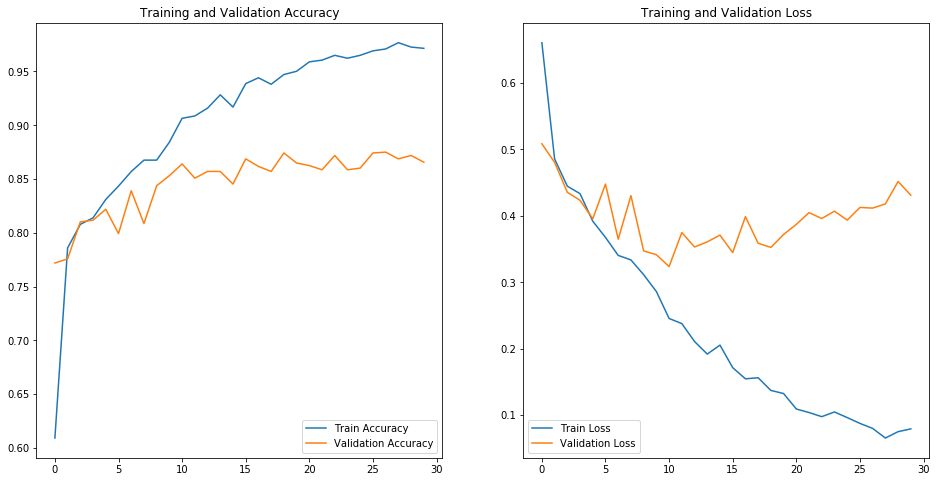

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

## half FC 0.8 0.8

In [28]:
model_8 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.8),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.8),
    Dense(1, activation='sigmoid')
])

model_8.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_8.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 112, 112, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)       

In [29]:
history = model_8.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/30
 9/40 [=====>........................] - ETA: 15s - loss: 0.6091 - acc: 0.6502

C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


40/40 [==============================] - 27s 686ms/step - loss: 0.6912 - acc: 0.5803 - val_loss: 0.6060 - val_acc: 0.6516
Epoch 2/30
40/40 [==============================] - 27s 674ms/step - loss: 0.5529 - acc: 0.7341 - val_loss: 0.5363 - val_acc: 0.7406
Epoch 3/30
40/40 [==============================] - 27s 663ms/step - loss: 0.5041 - acc: 0.7693 - val_loss: 0.5280 - val_acc: 0.7367
Epoch 4/30
40/40 [==============================] - 26s 655ms/step - loss: 0.4582 - acc: 0.7968 - val_loss: 0.5060 - val_acc: 0.7461
Epoch 5/30
40/40 [==============================] - 26s 647ms/step - loss: 0.4494 - acc: 0.8035 - val_loss: 0.4535 - val_acc: 0.7859
Epoch 6/30
40/40 [==============================] - 26s 655ms/step - loss: 0.4187 - acc: 0.8222 - val_loss: 0.3945 - val_acc: 0.8281
Epoch 7/30
40/40 [==============================] - 27s 679ms/step - loss: 0.4080 - acc: 0.8262 - val_loss: 0.4274 - val_acc: 0.8062
Epoch 8/30
40/40 [==============================] - 27s 675ms/step - loss: 0.398

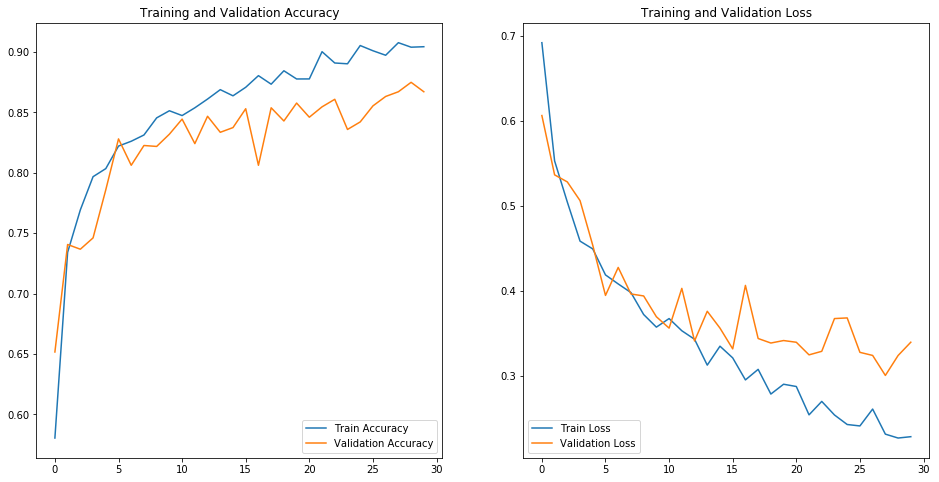

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

In [32]:
history = model_8.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/10
40/40 [==============================] - 26s 644ms/step - loss: 0.2079 - acc: 0.9141 - val_loss: 0.3177 - val_acc: 0.8695
Epoch 2/10
40/40 [==============================] - 26s 656ms/step - loss: 0.2153 - acc: 0.9098 - val_loss: 0.2984 - val_acc: 0.8789
Epoch 3/10
40/40 [==============================] - 25s 620ms/step - loss: 0.1994 - acc: 0.9179 - val_loss: 0.3075 - val_acc: 0.8664
Epoch 4/10
40/40 [==============================] - 26s 654ms/step - loss: 0.2061 - acc: 0.9188 - val_loss: 0.3702 - val_acc: 0.8453
Epoch 5/10
40/40 [==============================] - 26s 660ms/step - loss: 0.2010 - acc: 0.9172 - val_loss: 0.3137 - val_acc: 0.8805
Epoch 6/10
40/40 [==============================] - 25s 620ms/step - loss: 0.1949 - acc: 0.9255 - val_loss: 0.3074 - val_acc: 0.8742
Epoch 7/10
40/40 [==============================] - 25s 626ms/step - loss: 0.1761 - acc: 0.9253 - val_loss: 0.2969 - val_acc: 0.8719
Epoch 8/10
40/40 [==============================] - 25s 616ms/step - 

In [36]:
history.history['val_acc']

[0.8695313,
 0.87890625,
 0.86640626,
 0.8453125,
 0.8804687,
 0.87421876,
 0.871875,
 0.8765625,
 0.859375,
 0.87890625]

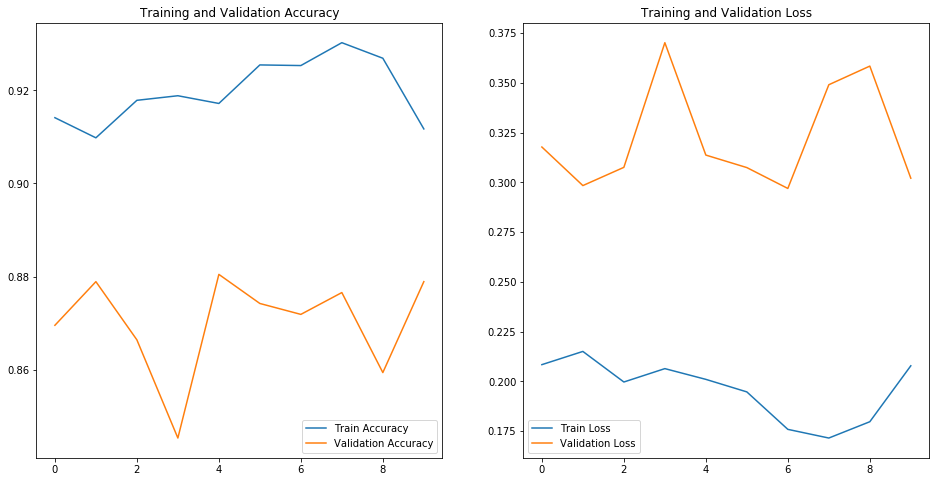

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

In [11]:
model_9 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.9),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.9),
    Dense(1, activation='sigmoid')
])

model_9.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_9.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)       

In [12]:
history = model_9.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/20
39/40 [============================>.] - ETA: 1s - loss: 0.6762 - acc: 0.6170Epoch 1/20


C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


40/40 [==============================] - 86s 2s/step - loss: 0.6710 - acc: 0.6204 - val_loss: 0.5230 - val_acc: 0.7477
Epoch 2/20
40/40 [==============================] - 75s 2s/step - loss: 0.5347 - acc: 0.7518 - val_loss: 0.5572 - val_acc: 0.7047
Epoch 3/20
40/40 [==============================] - 76s 2s/step - loss: 0.4904 - acc: 0.7807 - val_loss: 0.4719 - val_acc: 0.7766
Epoch 4/20
40/40 [==============================] - 74s 2s/step - loss: 0.4712 - acc: 0.7909 - val_loss: 0.4874 - val_acc: 0.7594
Epoch 5/20
40/40 [==============================] - 76s 2s/step - loss: 0.4815 - acc: 0.7923 - val_loss: 0.4399 - val_acc: 0.8047
Epoch 6/20
40/40 [==============================] - 78s 2s/step - loss: 0.4549 - acc: 0.8019 - val_loss: 0.4329 - val_acc: 0.8023
Epoch 7/20
40/40 [==============================] - 78s 2s/step - loss: 0.4515 - acc: 0.8059 - val_loss: 0.4283 - val_acc: 0.8016
Epoch 8/20
40/40 [==============================] - 72s 2s/step - loss: 0.4376 - acc: 0.8102 - val_lo